In [ ]:
!which python
!echo $CONDA_DEFAULT_ENV

In [ ]:
# on mommadragonn conda environment
import momma_dragonn
import deeplift

In [ ]:
# on dragonn conda environment
import dragonn
import deeplift

# Load model architecture and weights, generate and score test predictions

In [1]:
# REQUIRES NUMPY 1.13, DRAGONN USES NUMPY 1.11.3

from keras.models import model_from_json, model_from_yaml
import json

modelID = "record_2_model_Yjv2n_"

json_path = "../model_files/regressionJun24Positives/" + modelID + "modelJson.json"
with open(json_path) as json_file:
    json_string = json.dumps(json.load(json_file))
    model = model_from_json(json_string)  

model.load_weights("../model_files/regressionJun24Positives/" + modelID + "modelWeights.h5")
    
# plot(model, to_file= "../model_files/plots/" + modelID + "model.png")

# print model.summary()

Using Theano backend.
/home/users/rmovva/.local/lib/python2.7/site-packages/theano/gpuarray/dnn.py:135: UserWarning: Your cuDNN version is more recent than Theano. If you encounter problems, try updating Theano or downgrading cuDNN to version 5.1.
  warnings.warn("Your cuDNN version is more recent than "
Using cuDNN version 6020 on context None
Mapped name None to device cuda: Tesla P100-PCIE-16GB (0000:82:00.0)


Exception: ('Unrecognized model:', None)

In [4]:
!which python

/home/users/rmovva/anaconda2/bin/python


In [ ]:
import h5py
import numpy as np

with h5py.File('../hdf5files/regressionJun24Positives/test_data.hdf5') as f:
    print f.keys()
    x_data = f['X']
    y_data = f['Y']
    x_test = np.array(x_data['sequence'])
    y_test = np.array(y_data['output'])
    
# y_pred = model.predict(x_test)

In [ ]:
import numpy as np

y_pred = np.genfromtxt('../predictions/regressionJun24Positives_predictions.txt', delimiter='\t')
print y_test.shape
print y_pred.shape

In [ ]:
from scipy.stats import pearsonr, spearmanr
print "Avg signal predictions Pearson = " + str(pearsonr(y_pred[:, 0], y_test[:, 0]))
print "Avg signal predictions Spearman = " + str(spearmanr(y_pred[:, 0], y_test[:, 0]))
print "Rep1 signal predictions Pearson = " + str(pearsonr(y_pred[:, 1], y_test[:, 1]))
print "Rep1 signal predictions Spearman = " + str(spearmanr(y_pred[:, 1], y_test[:, 1]))
print "Rep2 signal predictions Pearson = " + str(pearsonr(y_pred[:, 2], y_test[:, 2]))
print "Rep2 signal predictions Spearman = " + str(spearmanr(y_pred[:, 2], y_test[:, 2]))

# Visualize model conv filters using dragonn.plot

In [ ]:
import h5py

modelID = "record_7_model_nVKX8_"
weightsFileName = "../model_files/regressionJun24Positives/" + modelID + "modelWeights.h5"
weights = h5py.File(weightsFileName, 'r')
print weights.keys()

In [ ]:
import numpy as np

layer = 'convolution1d_1'
# print np.array(weights[layer][str(layer + '_W')])
conv1_weights = np.array(weights[layer][str(layer + '_W')])
conv1_biases = np.array(weights[layer][str(layer + '_b')])
print conv1_weights.shape
print conv1_biases.shape
conv1_weights = np.reshape(conv1_weights, (len(conv1_weights), len(conv1_weights[0, 0]), len(conv1_weights[0, 0, 0])))

In [ ]:
print conv1_weights.shape
print np.mean(conv1_weights[:, :, 0], axis=1)
# print np.argmax(conv1_weights[:, :, 0], axis=1)
print np.mean(conv1_weights, axis = 1).shape
print np.mean(conv1_weights, axis = 1)[:, 0]
# conv1_weights_norm = conv1_weights - np.mean(conv1_weights, axis)

In [ ]:
# import matplotlib
# matplotlib.use('Agg')

import matplotlib.pyplot as plt
from dragonn import plot
fig = plot.plot_bases(conv1_weights[:, :, 12])
plt.show()
# fig.savefig('../model_files/regressionJun24Positives/plots/conv1_filter0.png')

In [ ]:
def softmax(matrix):
    probs = np.exp(10*matrix[:, :]) / np.repeat(np.reshape(np.sum(np.exp(10*matrix[:, :]), axis = 1), (19, 1, 300)), 4, axis=1)
    return probs

conv_filters_pwms = softmax(conv1_weights)
print conv_filters_pwms.shape
print conv_filters_pwms[:, :, 0]
print np.argmax(conv_filters_pwms[:, :, 0], axis=1)

In [ ]:
import matplotlib.pyplot as plt
from dragonn import plot
fig = plot.plot_pwm(conv_filters_pwms[:, :, 0])
plt.show()

# Write filters to MEME format for TOMTOM analysis

In [ ]:
np.savetxt("../model_files/regressionJun24Positives/interpretation/motifMatrices_conv1.txt",
           conv_filters_pwms[:, :, 0],
           delimiter = '\t',
           fmt = '%s')

In [ ]:
def filter_to_sequence(matrix):
    maxedMatrix = np.argmax(conv_filters_pwms, axis = 1)
    bases = {0: 'A', 1: 'C', 2: 'G', 3: 'T'}
    motifMatrix = np.vectorize(bases.get)(maxedMatrix)
    motifMatrix = np.swapaxes(motifMatrix, 0, 1)
    print motifMatrix.shape
    motifs = []
    for arr in motifMatrix:
        arr = list(arr)
        motifs.append(''.join(arr))
    return motifs
    
motifs = filter_to_sequence(conv_filters_pwms)
motifsFile = open('../model_files/regressionJun24Positives/interpretation/conv_filters_transformed_motifs.txt', 'w')
for i in range(len(motifs)):
    motifsFile.write('>conv1_filter' + str(i) + '\n')
    motifsFile.write(motifs[i] + '\n')
motifsFile.close()

In [ ]:
meme = open('../model_files/regressionJun24Positives/interpretation/conv_filters_meme_format.txt', 'w')
meme.write("MEME version 4\n\nALPHABET = ACGT\n\nStrands: + -\n\n" +
           "Background letter frequencies\nA 0.25 C 0.25 G 0.25 T 0.25\n\n")
conv_filter_pwms_reaxis = np.swapaxes(conv_filters_pwms, 0, 2)
conv_filter_pwms_reaxis = np.swapaxes(conv_filter_pwms_reaxis, 1, 2)
for i in range(len(conv_filter_pwms_reaxis)):
# for i in range(2):
    meme.write('MOTIF conv1_filter' + str(i) + '\n')
    meme.write('letter-probability matrix: alength= 4 w= 19\n')
    for j in range(len(conv_filter_pwms_reaxis[i])):
        meme.write(' '.join(conv_filter_pwms_reaxis[i, j].astype(np.str)) + '\n')
    meme.write('\n')

# Compare filters to known motifs using PWM cross-correlation method

In [ ]:
import glob
import os, sys
import h5py

import numpy as np
from scipy.signal import correlate2d
import pandas as pd

import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt

In [ ]:
### Define classes and functions
##################################################################
class PWM(object):
    def __init__(self, weights, name=None, threshold=None):
        self.weights = weights
        self.name = name
        self.threshold = threshold

    @staticmethod
    def from_homer_motif(motif_file):
        with open(motif_file) as fp:
            header = fp.readline().strip().split('\t')
            name = header[1]
            threshold = float(header[2])
            weights = np.loadtxt(fp)

        return PWM(weights, name, threshold)

    @staticmethod
    def get_encode_pwms(motif_file):
        pwms = []
        with open(motif_file) as fp:
            line = fp.readline().strip()
            while True:
                if line == '':
                    break

                header = line
                weights = []
                while True:
                    line = fp.readline()
                    if line == '' or line[0] == '>':
                        break
                    weights.append(map(float, line.split()[1:]))
                pwms.append(PWM(np.array(weights), header))
        return pwms

    @staticmethod
    def from_cisbp_motif(motif_file):
        name = os.path.basename(motif_file)
        with open(motif_file) as fp:
            _ = fp.readline()
            weights = np.loadtxt(fp)[:, 1:]
        return PWM(weights, name)

def load_all_pwms():
    homer_path = '../../data/motifs/homer/*.motif'
    homer_pwms = [PWM.from_homer_motif(motif_file)
            for motif_file in glob.glob(homer_path)]

    encode_motifs = '../../data/motifs/encode/motifs.txt'
    encode_pwms = PWM.get_encode_pwms(encode_motifs)

    cisbp_motifs_path = '../../data/motifs/cisbp/*.txt'
    cisbp_annots = pd.read_table("../../data/motifs/cisbp/annots/cisbp_TF_ids.txt")
    cisbp_pwms = [PWM.from_cisbp_motif(motif_file) 
                  for motif_file in glob.glob(cisbp_motifs_path)]

    id_list = cisbp_annots.ix[:,"Motif_ID"].tolist()
    for pwm in cisbp_pwms:
        if pwm.name.split('.txt')[0] in id_list:
            ind = id_list.index(pwm.name.split('.txt')[0])
            pwm.name = cisbp_annots.ix[ind,"TF_Name"]
    return (homer_pwms, encode_pwms, cisbp_pwms)

# Load weights for layer 
def loadWeightsForLayer(h5file, layerName):
    f = h5file
    print f.keys()
#     g=f['layer_{}'.format(layerIdx)] #gets the first layer
#     weights = [g['param_{}'.format(p)] for p in range(g.attrs['nb_params'])]
    weights = f[layerName][str(layerName + '_W')]
    weights = np.array(weights)
    weights = np.reshape(weights, (len(weights), len(weights[0, 0]), len(weights[0, 0, 0])))
    return np.array(weights)

# Get the maximal and minimal cross correlation between PWM and Filter
# Notes: can play with fillvalue of 0 or 0.25
def max_min_cross_corr(pwm, conv_filter):
    if conv_filter.shape[1] != 4:
        conv_filter = conv_filter.T
    assert conv_filter.shape[1] == 4
    assert pwm.shape[1] == 4
    
    corr = correlate2d(pwm, conv_filter, mode='same', fillvalue=0.)
    # we are only interested in the part where the 'letter' axes are aligned,
    # and the correlation is over the position axis only, which is in the 2nd
    # column
    allowed_corr = corr[:, 1]
    max_corr = np.max(allowed_corr)
    min_corr = np.min(allowed_corr)

    # max_pos (and min_pos) relates to the alignment between the pwm and the
    # conv_filter as follows - more generally,
    #
    # Position floor(w / 2) - i maps to position 0 on the (padded) PWM
    #
    # where w = width of conv filter, and i is the position given by best_pos
    # (or more generally, the index into allowed_corr). If a negative position
    # is obtained, that means that position 0 on the conv_filter maps to a
    # later position on the PWM.
    max_pos = np.argmax(allowed_corr)
    min_pos = np.argmin(allowed_corr)

    return ((max_corr, max_pos), (min_corr, min_pos))

# Use to get PWM matches for a given filter 
# Normalize filter by max/min activation
def get_pwm_matches_for_filter(conv_filter, pwms, topk=10, bottomk=None):

    min_activation = conv_filter.min(axis=0).sum()
    max_activation = conv_filter.max(axis=0).sum()
    activation_range = max_activation - min_activation

    def norm_cc(cc):
        return (cc - min_activation) / activation_range

    hits = []

    for idx, pwm in enumerate(pwms):
        (max_cc, max_pos), (min_cc, min_pos) = \
            max_min_cross_corr(pwm.weights, conv_filter)
        (max_cc_rc, max_pos_rc), (min_cc_rc, min_pos_rc) = \
            max_min_cross_corr(pwm.weights, conv_filter[::-1,::-1])

        if max_cc_rc > max_cc:
            hits.append((norm_cc(max_cc_rc), max_pos_rc, idx, pwm.name))
        else:
            hits.append((norm_cc(max_cc), max_pos, idx, pwm.name))
        if bottomk != None:
            hits.append((norm_cc(min_cc), min_pos, idx, pwm.name))

        hits.sort(reverse=True)

    if bottomk == None:
        return hits[:topk]
    else:
        return hits[:topk] + hits[-bottomk:]

In [ ]:
homer_pwms, encode_pwms, cisbp_pwms = load_all_pwms()

In [ ]:
print ("There are " + str(len(homer_pwms)) + " HOMER motifs, " 
       + str(len(encode_pwms)) + " ENCODE motifs, and "
       + str(len(cisbp_pwms)) + " CISBP motifs.")
all_pwms = homer_pwms + encode_pwms + cisbp_pwms
print "In total, there are " + str(len(all_pwms)) + " motifs."

In [ ]:
modelID = "record_1_model_aG0ad_"
model_weights_h5 = h5py.File("../model_files/regressionJun24Positives/" + modelID + "modelWeights.h5")
conv_weights = loadWeightsForLayer(model_weights_h5, layerName = 'convolution1d_1')

In [ ]:
print conv_weights.shape

In [ ]:
from scipy.stats import pearsonr

print all_pwms[0].weights.shape
print conv_weights[:, :, 0].shape
print correlate2d(all_pwms[0].weights, conv_weights[:, :, 0], mode='same', fillvalue=0.)[:, 1].shape
print correlate2d(all_pwms[0].weights, conv_weights[:, :, 0], mode='same', fillvalue=0.)[:, 1]

print get_pwm_matches_for_filter(conv_weights[:, :, 0], all_pwms, topk=1, bottomk=1)

In [ ]:
conv_filter_pwm_matches = [get_pwm_matches_for_filter(conv_filter = conv_weights[:,:,i], 
                                                      pwms = all_pwms, 
                                                      topk = 3, 
                                                      bottomk = 3)
                          for i in range(conv_weights.shape[2])]
# conv_filter_pwm_matches_test = get_pwm_matches_for_filter(conv_filter = conv_weights[:,:,0], 
#                                                           pwms = all_pwms, 
#                                                           topk = 10, 
#                                                           bottomk = None)

In [ ]:
conv_filter_pwm_matches = np.array(conv_filter_pwm_matches)

In [ ]:
print conv_filter_pwm_matches[:, :, :]

In [ ]:
import matplotlib.pyplot as plt
from dragonn import plot
fig = plot.plot_bases(conv1_weights[:, :, 2])
plt.show()

In [ ]:
def filter_to_sequence(matrix):
    maxedMatrix = np.argmax(matrix, axis = 1)
    bases = {0: 'A', 1: 'C', 2: 'G', 3: 'T'}
    motifMatrix = np.vectorize(bases.get)(maxedMatrix)
    motifMatrix = np.swapaxes(motifMatrix, 0, 1)
    print motifMatrix.shape
    motifs = []
    for arr in motifMatrix:
        arr = list(arr)
        motifs.append(''.join(arr))
    return motifs
    
motifs = filter_to_sequence(conv_weights)
motifsFile = open('../model_files/regressionJun24Positives/interpretation/conv_filters_20_transformed_motifs.txt', 'w')
for i in range(len(motifs)):
    motifsFile.write('>conv1_filter' + str(i) + '\n')
    motifsFile.write(motifs[i] + '\n')
motifsFile.close()

In [ ]:
from dragonn import plot

# Visualize filter and save to plot_name with provided output_prefix and title
def plot_filter_motif(motif_filter, output_prefix, title, plot_name):
    
    # motif_filter = filters[0, ...].squeeze()

    assert len(motif_filter.shape) == 2
    assert 4 in motif_filter.shape

    # May need to transpose as plot_bases takes a N x 4 array
    if motif_filter.shape[0] == 4:
        motif_filter = motif_filter.T

    motif_filter -= motif_filter.mean(axis=1, keepdims=True)
    motif_filter *= 10

    plt.close()
    plot.plot_bases(motif_filter, ylab = 'Weight (x 10)')
    plt.title('{}'.format(title))
    plt.show()
    #     plt.savefig(plot_name)

In [ ]:
plot_filter_motif(conv_weights[:, :, 12],
                output_prefix='',
                title=modelID + ' conv_filter0',
                plot_name='../model_files/regressionJun24Positives/plots/' + modelID + '_conv_filter0')

# DeepLIFT interpretation of top-scoring sequence features

Much of this code is taken from this DeepLIFT Modisco tutorial: https://github.com/kundajelab/deeplift_modisco_tutorial/blob/master/DeepLIFT%20%2B%20MoDISco%20tutorial.ipynb

Also, this is another tutorial that Avanti mentioned that may work better but is harder / requires more dependencies to run: https://github.com/kundajelab/modisco_experiments/blob/master/Nanog/ClusterSeqlets-sequencesGrads.ipynb

In [ ]:
%load_ext autoreload

In [ ]:
%autoreload 1
%aimport deeplift

In [10]:
%matplotlib inline
# from __future__ import print_function
from simdna import synthetic as sn
import avutils
from avutils import file_processing as fp
import numpy as np
from collections import OrderedDict
# import tutorial_utils
# from tutorial_utils import viz_sequence_highlight_motifs
from deeplift.blobs import NonlinearMxtsMode, DenseMxtsMode
import deeplift
import deeplift.conversion.keras_conversion as kc
from deeplift.visualization import viz_sequence
# import modisco_tutorial

In [11]:
# Load the keras model, make sure you normalise the weights
# of the first convolutional layer to be mean-centered at each position.
modelName = "record_4_model_iGIVc_"
# modelName = "record_2_model_Yjv2n_"
modelJson = "../model_files/regression_jul3_strands_augmented/" + modelName + "modelJson.json"
modelWeights = "../model_files/regression_jul3_strands_augmented/" + modelName + "modelWeights.h5"
reload(kc)
keras_model = kc.load_keras_model(modelWeights, json=modelJson)

In [ ]:
# normalization doesn't work b/c the zero-padding violates one-hot encoding
# # normalize weights
# W, b = keras_model.layers[0].get_weights()
# # print W[:, :, :, 0]
# mean_W = np.mean(W, axis = -2)
# # print mean_W[:, :, 0]
# W = W - mean_W[:, :, None, :]
# # print W[:, :, :, 0]
# # print b.shape
# b = b + np.squeeze(np.sum(mean_W,axis=0))
# keras_model.layers[0].set_weights([W, b])

In [12]:
import momma_dragonn
# load the validation set
valid_path = "../hdf5files/regression_jul3_strands_augmented_rep2only/valid_data.hdf5"
data = (momma_dragonn.data_loaders.hdf5_data_loader
              .MultimodalAtOnceDataLoader(path_to_hdf5=valid_path,
                                          strip_enclosing_dictionary=True)
              .get_data())

Input modes [u'sequence']
Output modes [u'output']


In [ ]:
data_predictions = keras_model.predict(data.X)
print(data_predictions.shape)

In [ ]:
from scipy.stats import spearmanr, pearsonr
# prediction performance goes down b/c of the weight normalization. not sure if this is "bad"?
print spearmanr(data_predictions, data.Y)

In [ ]:
deeplift_model = kc.convert_sequential_model(keras_model,
                                             nonlinear_mxts_mode=deeplift.blobs.NonlinearMxtsMode.DeepLIFT_GenomicsDefault)

# keras_model.layers

In [ ]:
deeplift_model.get_layers()

In [ ]:
deeplift_prediction_function = deeplift_model.get_prediction_function(
    input_layer_idx = 0,
    output_layer_idx = -1
)

In [13]:
# DeepLIFT model sanity check
# deeplift_model_predictions = deeplift_prediction_function([data.X], batch_size=500)
# print spearmanr(deeplift_model_predictions, data.Y) # should be ~0.34
keras_model_predictions = keras_model.predict([data.X], batch_size=500)
# print(np.mean(np.abs(deeplift_model_predictions - keras_model_predictions)))
# print(np.max(np.abs(deeplift_model_predictions - keras_model_predictions)))
# print spearmanr(deeplift_model_predictions, keras_model_predictions) # should be ~1

In [ ]:
deeplift_scoring_func = deeplift_model.get_target_contribs_func(
                            find_scores_layer_idx = 0,
                            target_layer_idx = -1)

In [ ]:
import sys
import h5py
import numpy as np

def get_background_frequencies(filepath):
    try:
        f = h5py.File(filepath)
    except:
        sys.exit("Either there is no file called " + filepath + ", or it's not an HDF5 file.")
    
    sample = 3000
    indices = np.random.choice(np.arange(len(f['X']['sequence'])), sample, replace = False)
    print len(indices)
    print indices[:10]
    
    sequences = np.take(np.array(f['X']['sequence']), indices, axis=0)
    print sequences[0]
    
    i=0
    baseCounts = [0, 0, 0, 0]
    for seq in sequences:
        if i % 1e3 == 0:
            print i
        for base in seq:
            if float(np.sum(base)) > 0.0:
#                 if i == 0:
#                     print np.sum(base)
                baseCounts[np.argmax(base)] += 1
        i += 1
    
    return np.array(baseCounts) / float(np.sum(baseCounts))

# this could take a while - up to ~15 minutes (approx. numSamples/500 minutes)
valPath = "../hdf5files/regressionJun24Positives/valid_data.hdf5"
backgroundFrequencies = get_background_frequencies(valPath)

In [ ]:
# with sample 1000: [ 0.28861706  0.20773624  0.20896315  0.29468356]
backgroundFrequencies = np.array([0.2905, 0.205, 0.2075, 0.297])
print backgroundFrequencies

In [ ]:
# [None,None,:,None] refers to the broadcast pattern; one_hot_data
# has dimensions: sample x channel x rows x columns
# the rows are acgt, the columns refer to the position
# along the sequence, and the channel is a dummy axis for the first input layer.
# Thus, we will broadcast over sample, channel and columns.
print data.X.shape
# one_hot_data = np.expand_dims(data.X, axis=1)
# print one_hot_data.shape
# one_hot_data = np.swapaxes(one_hot_data, 2, 3)
# print one_hot_data.shape
# referenceBackground = np.ones_like(one_hot_data)*backgroundFrequencies[None,None,:,None]
referenceBackground = np.ones_like(data.X)*backgroundFrequencies[None,None,:]

In [ ]:
print data.X.shape
# print one_hot_data.shape
print referenceBackground.shape
# print data.X[0:2, 995:1005, :]
# print(one_hot_data[0:2, :, :, 995:1005])
# print(referenceBackground[0:2, :, :, 995:1005])

In [ ]:
import sys

letter_list = ['N', 'A', 'C', 'G', 'T']

def convert_one_hot_seq_to_acgt(one_hot_seq):
#     print one_hot_seq.shape
    seq = ''
    seqLen = int(np.sum(one_hot_seq))
#     print np.unique(one_hot_seq, return_counts=True)
#     sys.exit(0)
    left_pad = (2000 - seqLen)/2
    if seqLen % 2 == 0:
        right_pad = (2000 - seqLen)/2
    else:
        right_pad = (2000 - seqLen)/2 + 1
    seq += 'N' * left_pad
    for i in range(seqLen):
        seq += letter_list[np.argmax(one_hot_seq[left_pad + i]) + 1]
    seq += 'N' * right_pad
#     print(len(seq))
#     print(seq)
#     print seqLen
#     sys.exit(0)
    return seq, (left_pad, right_pad)
    

In [ ]:
import time
t0 = time.time()
input_data_sequences = []
print_interval = int(2e4)
seq_pad_lengths = []
for (i, seq) in enumerate(data.X):
    if i % print_interval == 0 and i > 0:
        print ("Converting sequences " + str(i - print_interval) +
               " to " + str(i) + " from one-hot to ACGT strings took " +
               str(round(time.time() - t0, 3)) + "s.")
        t0 = time.time()
    char_seq, pads = convert_one_hot_seq_to_acgt(seq)
    input_data_sequences.append(char_seq)
    seq_pad_lengths.append(pads)

In [ ]:
input_data_sequences = np.array(input_data_sequences)
seq_pad_lengths = np.array(seq_pad_lengths)

In [ ]:
np.savetxt(fname = '../splits/regression_jul3_strands_augmented/val_split_input_data_sequences.txt',
           fmt = '%s',
           X = input_data_sequences,
           delimiter = '\t', 
           header = '',
           comments = '')

np.savetxt(fname = '../splits/regression_jul3_strands_augmented/val_split_sequence_pad_lengths.txt',
           fmt = '%s',
           X = seq_pad_lengths,
           delimiter = '\t',
           header = '',
           comments = '')

In [ ]:
input_data_sequences = np.loadtxt(fname = '../splits/regression_jul3_strands_augmented/val_split_input_data_sequences.txt',
                                  dtype = 'string',
                                  delimiter = '\t', 
                                  comments = '')

seq_pad_lengths = np.loadtxt(fname = '../splits/regression_jul3_strands_augmented/val_split_sequence_pad_lengths.txt',
                             dtype = np.uint16,
                             delimiter = '\t',
                             comments = '')

In [ ]:
import avutils
reload(deeplift)
reload(deeplift.dinuc_shuffle)
from deeplift.dinuc_shuffle import dinuc_shuffle

seed = 710
deeplift_many_refs_func = deeplift.util.get_shuffle_seq_ref_function(
                                score_computation_function=deeplift_scoring_func, #supply any deeplift scoring function
                                shuffle_func=deeplift.dinuc_shuffle.dinuc_shuffle,
                                seed=seed,
                                #func to one-hot encode array of sequences:
                                # one_hot_func=lambda x: np.array([np.swapaxes(avutils.util.seq_to_one_hot(seq), 0, 1) for seq in x]) #theano_seq_to_2d_image, seq_to_one_hot
                                one_hot_func=lambda x: np.array([avutils.util.seq_to_one_hot(seq) for seq in x]) #theano_seq_to_2d_image, seq_to_one_hot
                            )

In [ ]:
reload(deeplift.dinuc_shuffle)
from deeplift import dinuc_shuffle
# print input_data_sequences[0]
# print seq_pad_lengths[0]
dinuc_shuffle.dinuc_shuffle(input_data_sequences[0], list(seq_pad_lengths[0]))

In [ ]:
task_to_deeplift_multipliers = OrderedDict()
for task_idx in [0]:
    task_to_deeplift_multipliers[task_idx] = np.array(deeplift_many_refs_func(
                                                      task_idx = task_idx,
                                                      input_data_sequences=input_data_sequences,
                                                      num_refs_per_seq=10,
                                                      batch_size=500,
                                                      padded_length=2000,
                                                      pad_lengths=seq_pad_lengths,
                                                      progress_update=20000))
    
np.savetxt(fname = '../splits/regression_jul3_strands_augmented/val_split_deeplift_scores.txt',
           fmt = '%s',
           X = np.reshape(task_to_deeplift_multipliers[0], (-1, 8000)),
           delimiter = '\t', 
           header = '',
           comments = '')

In [ ]:
task_to_deeplift_multipliers = OrderedDict()
task_to_deeplift_multipliers[0] = np.genfromtxt(fname = '../splits/regression_jul3_strands_augmented/val_split_deeplift_scores.txt',
                                                dtype = 'string',
                                                delimiter = '\t', 
                                                comments = '')

In [ ]:
task_to_deeplift_multipliers[0] = np.reshape(task_to_deeplift_multipliers[0], (-1, 2000, 4))

In [ ]:
task_to_deeplift_scores_unsummed = OrderedDict()
for task_idx in [0]:
    task_to_deeplift_scores_unsummed[task_idx] = np.array(deeplift_scoring_func(
                                                task_idx=task_idx,
                                                input_data_list=[data.X],
                                                input_references_list=[referenceBackground],
                                                batch_size=500,
                                                # if you pass an integer for progress_update, you will get
                                                # a message printed every time that number of items is processed
                                                progress_update=10000))

In [ ]:
print("Shape: ",str(task_to_deeplift_multipliers[0].shape))
# Notice that the scores of the first few bases are much smaller than the scores of the middle base pairs,
# since the scores of the first and last "base pairs" are actually just the zero pads
print(task_to_deeplift_multipliers[0][0][0:3][:])
print(task_to_deeplift_multipliers[0][0][1000:1003][:])

In [ ]:
task_to_deeplift_multipliers[0] = task_to_deeplift_multipliers[0].astype(np.float32)

In [ ]:
task_to_deeplift_scores = OrderedDict()
for task in task_to_deeplift_multipliers:
    task_to_deeplift_scores[task] = np.sum(task_to_deeplift_multipliers[task],axis=2)

In [ ]:
print task_to_deeplift_scores[0].shape

In [ ]:
print data.Y.shape

In [ ]:
import gzip
fragments = []
valSplitPath = "../splits/regression_jul3_strands_augmented/val_split.txt.gz"
with gzip.open(valSplitPath) as valNames:
    for line in valNames:
        fragments.append(line.strip())

In [14]:
chromhmm_annotations = open("../splits/regression_jul3_strands_augmented/val_split_regions_chromhmm_annotated_halfoverlap.bed").readlines()
states = []
for (i, line) in enumerate(chromhmm_annotations):
#     if i > 1000000:
#         break
    states.append(line.strip().split('\t')[9])

from collections import Counter
states_dict = Counter(states)
print len(states_dict.keys())
print states_dict

25
Counter({'Quies': 111908, 'Low': 32120, 'ReprW': 31580, 'Repr': 16360, 'Tss': 16010, 'EnhWF': 15020, 'TssF': 12902, 'Enh': 11026, 'EnhF': 10792, 'PromF': 8362, 'Ctcf': 7878, 'EnhW': 7538, 'ElonW': 7180, 'Elon': 6382, 'DnaseU': 4510, 'ReprD': 4072, "Gen5'": 3110, 'CtcfO': 3106, 'PromP': 2850, 'Pol2': 2708, 'DnaseD': 2490, "Gen3'": 2026, 'FaireW': 1656, 'H4K20': 1194, 'Art': 326})


In [15]:
from collections import OrderedDict

chromhmm_annotations = open("../splits/regression_jul3_strands_augmented/val_split_regions_chromhmm_annotated_halfoverlap.bed").readlines()
fragment_annotations = OrderedDict()
index_annotations = OrderedDict()
state_dict = OrderedDict({state: [] for state in states_dict.keys()})
index = 0
for line in chromhmm_annotations:
    line = line.strip().split('\t')
    name = line[3]
    state = line[9]
    overlap = int(line[-1])
    seqLen = int(line[2]) - int(line[1])
    overlapPct = round(float(overlap) / seqLen, 6)
    state_info = [state, index, overlapPct]
    addToIndex = False
    if name in fragment_annotations:
        if overlapPct > fragment_annotations[name][2]:
            fragment_annotations[name] = state_info
    else:
        addToIndex = True
    fragment_annotations[name] = state_info
    index_annotations[index] = [state, name, overlapPct]
    state_dict[state].append([name, index, overlapPct])
    if addToIndex:
        index += 1

In [16]:
print len(index_annotations.keys()) # should be val_size = 205984
print len(fragment_annotations.keys()) # should be size of chromhmm file
print len(state_dict.keys()) # should be 25, number of chromatin states

205984
205984
25


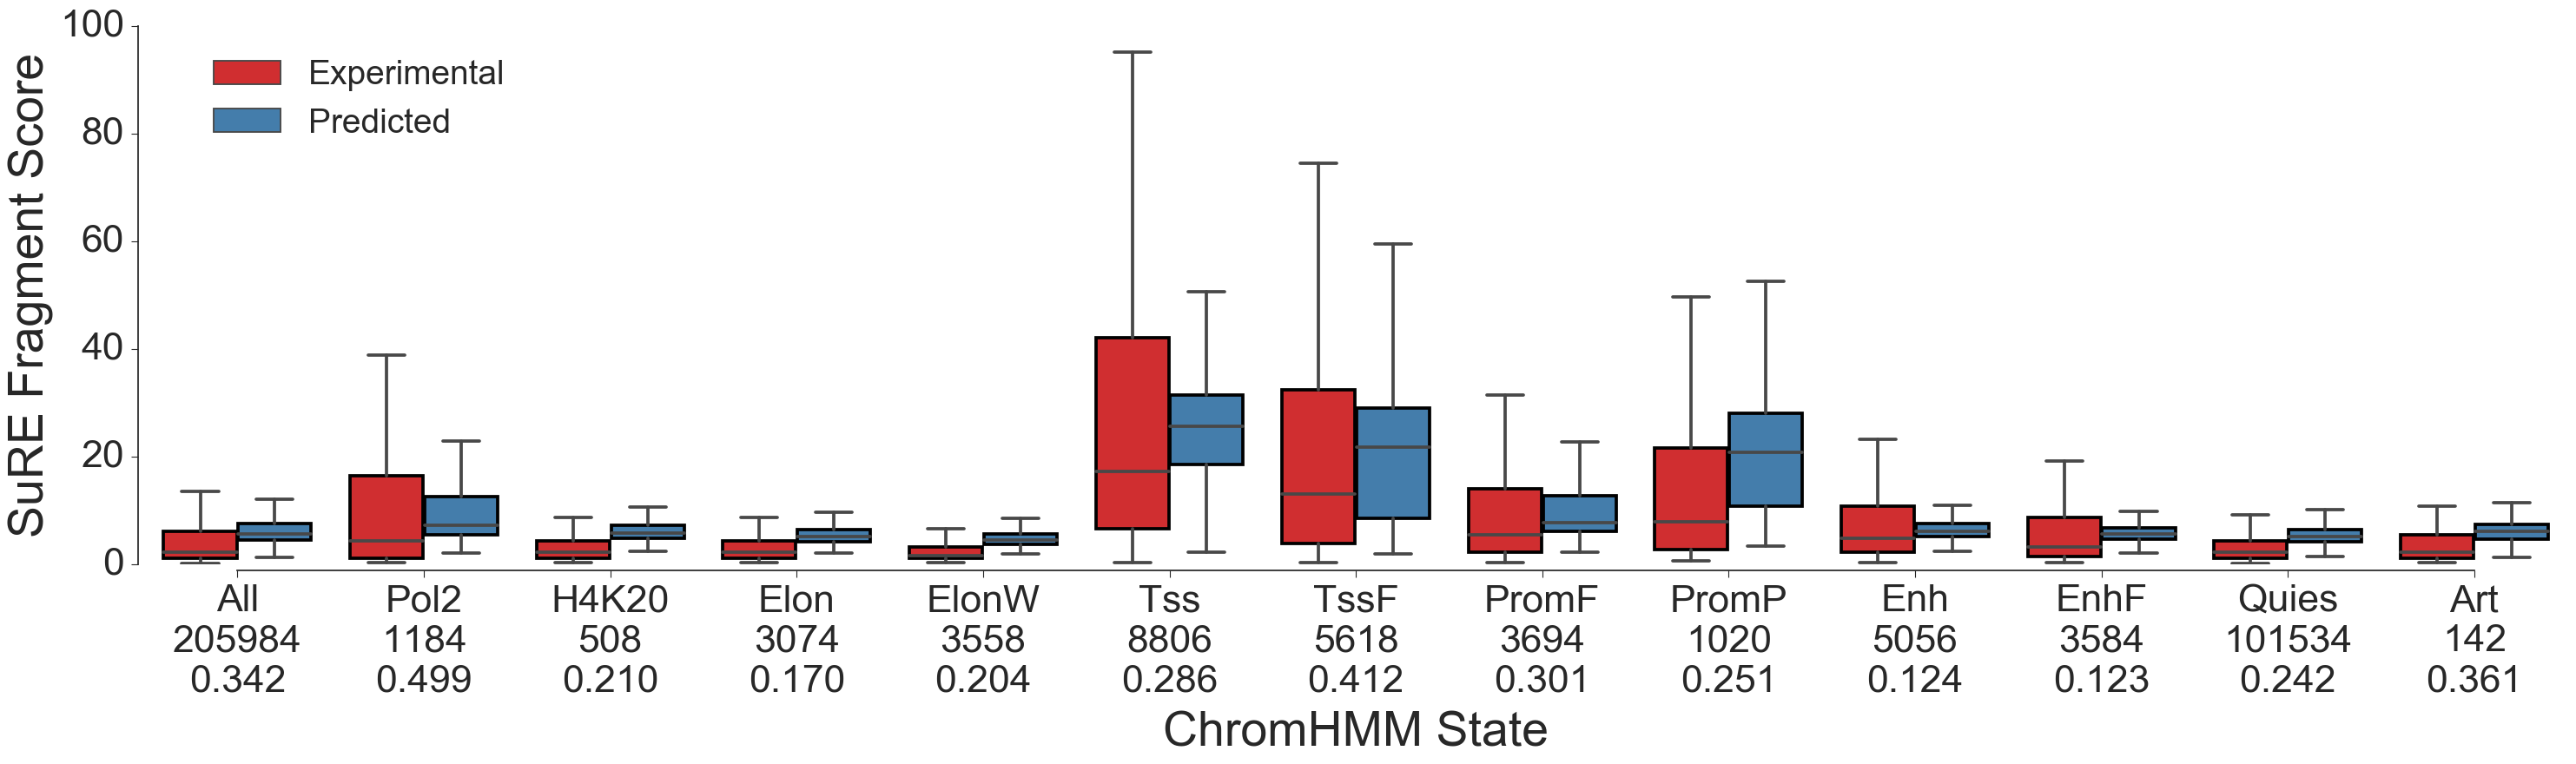

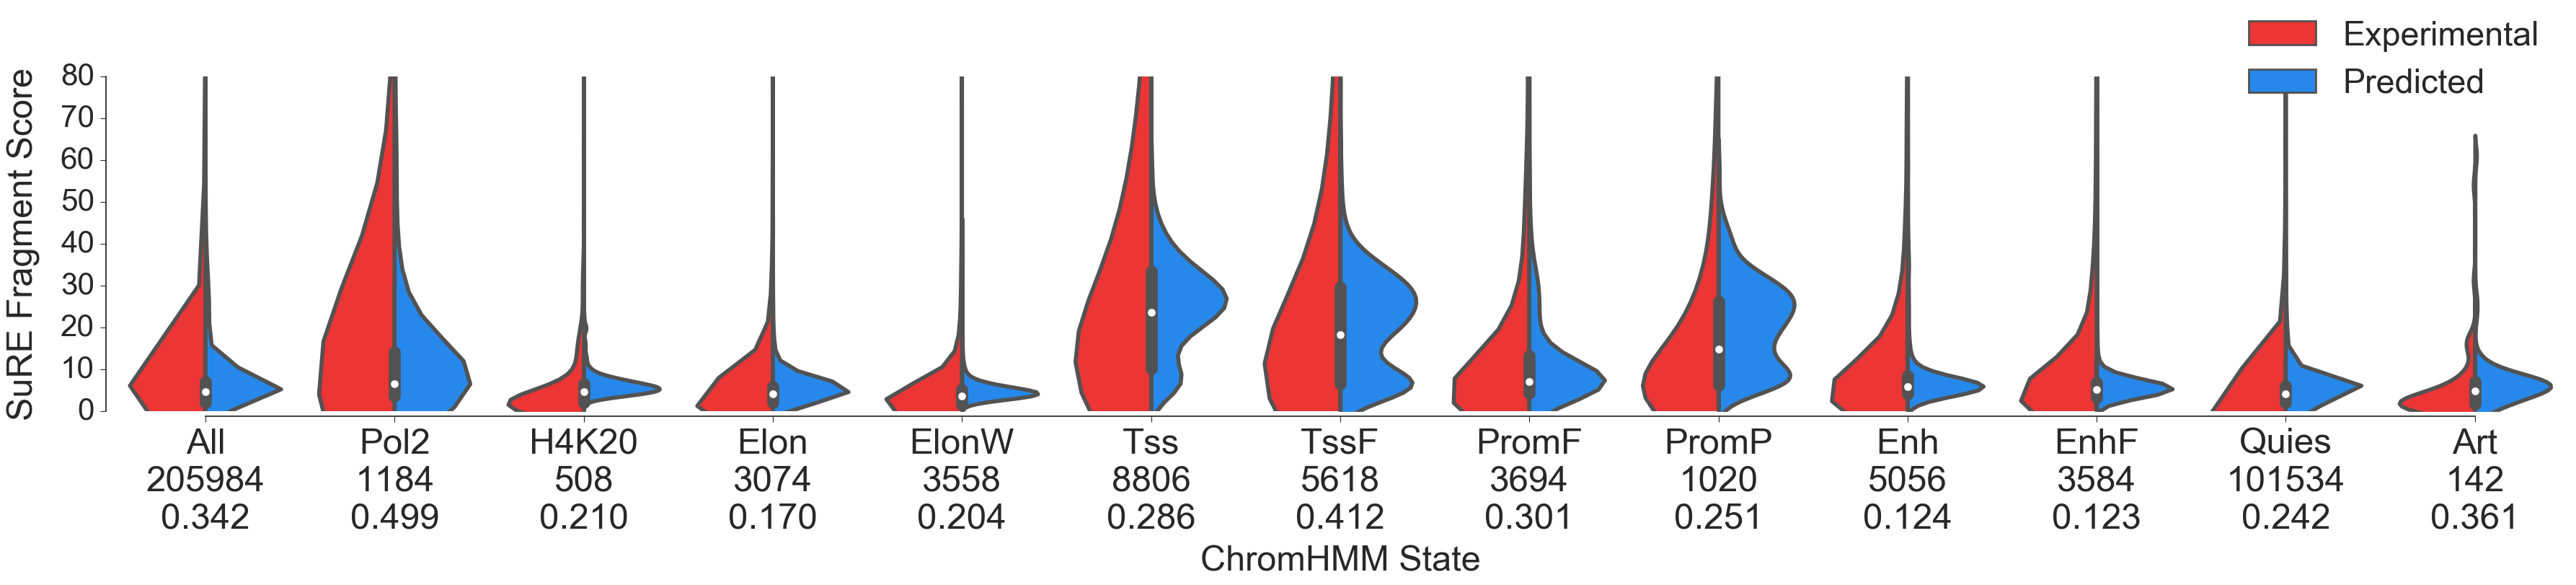

In [24]:
%matplotlib inline

from scipy.stats import spearmanr
import pandas as pd

plotted_chromhmm_states = ['All',
                           'Pol2', 'H4K20', 'Elon', 'ElonW',# "Gen5'", "Gen3'",
                           'Tss', 'TssF', 
                           'PromF', 'PromP', 
                           'Enh', 'EnhF',
#                            'EnhWF', 'EnhW', 'DnaseU', 'DnaseD', 'FaireW'
#                            'Repr', 'ReprW', 'ReprD', 
                           'Quies', 'Art', 
#                            'Low', 
#                            'Ctcf', 'CtcfO'
                          ]

predictions_by_state = {state: [[], []] for state in state_dict.keys()}
predictions_by_state['All'] = [[], []]
dfDict = {'ChromHMM State': [], 'Type': [], 'SuRE Fragment Score': []}
trues = []
preds = []
for index in index_annotations:
    state = index_annotations[index][0]
    y_true = data.Y[index]
    y_pred = keras_model_predictions[index]
    trues.append(y_true)
    preds.append(y_pred)
    predictions_by_state[state][0].append(y_true)
    predictions_by_state[state][1].append(y_pred)
    
    predictions_by_state['All'][0].append(y_true)
    predictions_by_state['All'][1].append(y_pred)
    
    if state in plotted_chromhmm_states:
        for pred_type in range(2):
            dfDict['ChromHMM State'].append(state)
            if pred_type == 0:
                dfDict['Type'].append('Experimental')
                dfDict['SuRE Fragment Score'].append(float(y_true))
            else:
                dfDict['Type'].append('Predicted')
                dfDict['SuRE Fragment Score'].append(float(y_pred))
    
    for pred_type in range(2):
        dfDict['ChromHMM State'].append('All')
        if pred_type == 0:
            dfDict['Type'].append('Experimental')
            dfDict['SuRE Fragment Score'].append(float(y_true))
        else:
            dfDict['Type'].append('Predicted')
            dfDict['SuRE Fragment Score'].append(float(y_pred))
                
pred_df = pd.DataFrame.from_dict(dfDict)
pred_df['ChromHMM State'] = pd.Categorical(
    pred_df['ChromHMM State'], 
    categories=plotted_chromhmm_states, 
    ordered=True
)
pred_df = pred_df.sort_values(by=['ChromHMM State', 'Type'])
# pred_df = pred_df[pred_df['SuRE Fragment Score'] < 100]
# print pred_df.head()        

num_examples_per_state = {}
for state in predictions_by_state:
    num_examples_per_state[state] = len(predictions_by_state[state][0])

corrs_by_state = {state: [float(spearmanr(predictions_by_state[state][0], predictions_by_state[state][1])[0]), 
                          float(max(spearmanr(predictions_by_state[state][0], predictions_by_state[state][1])[1], 
                                    np.finfo(np.float64).tiny))]   
                  for state in predictions_by_state}

# for state in corrs_by_state:
#     if corrs_by_state[state][1] < np.finfo(np.float64).tiny:
#         corrs_by_state[state][1] = np.finfo(np.float64).tiny
    
# states_with_names = ([state + '\n' + r'(n = ' + str(num_examples_per_state[state]) + ')'
#                       for state in pred_df['ChromHMM State']])

states_with_names = ([state + '\n' + 
                      str(num_examples_per_state[state]) 
                      + '\n' + "%.3f" % round(corrs_by_state[state][0], 3) 
#                       + '\n' + str(round(-1 * np.log10(corrs_by_state[state][1]), 1)) 
                      for state in pred_df['ChromHMM State']])

pred_df['ChromHMM State'] = states_with_names

# print pred_df.head()
                      
# for state in predictions_by_state:
#     corr, p = spearmanr(predictions_by_state[state][0], predictions_by_state[state][1])
#     print(state + ", Spearman = " + str(round(corr, 4)) + ", p = " + str(round(p, 4)) + 
#           " (n = " + str(len(predictions_by_state[state][0])) + ")")

import matplotlib.pyplot as plt
import seaborn as sns

sns.set()

upscale = 2
plt.figure(figsize=(18*upscale,4*upscale), dpi=300) # orient = 'v'
# plt.figure(figsize=(4,12)) # orient = 'h'
# plt.rc('font',family='cmr10')

rc = {'axes.labelsize': 20*upscale, 
      'legend.fontsize': 14*upscale, 
      'axes.titlesize': 15*upscale, 
      'xtick.labelsize': 16*upscale, 
      'ytick.labelsize': 16*upscale,
#       'font.sans-serif': 'Arial',
#       'font.family': 'sans-serif'
     }

sns.set(context='paper', 
        style='ticks', 
        palette=sns.color_palette("Set1", n_colors=8, desat=.8), 
        font='Arial', 
        font_scale=1, 
        color_codes=False, 
        rc=rc)

# plt.style.use('ticks')

ax = sns.boxplot(x="ChromHMM State", 
                 y="SuRE Fragment Score",
#                  orient = 'h',
                 orient = 'v',
                 hue="Type",
                 data=pred_df,
                 fliersize=0,
                 saturation=1,
                 linewidth=2.7);
ax.set_ylim([0,100]);
# ax.set_xlim([0,100]);
ax.xaxis.labelpad = 10;

for box in ax.artists:
    box.set_edgecolor('black')

sns.despine(offset=5, trim=True);
plt.legend(bbox_to_anchor=(0.25, 0.895),
           bbox_transform=plt.gcf().transFigure);

plt.show()

plt.figure(figsize=(22*upscale,4*upscale), dpi=300);

rc = {'axes.labelsize': 17.5*upscale, 
      'legend.fontsize': 16.8*upscale, 
      'axes.titlesize': 18*upscale, 
      'xtick.labelsize': 17.8*upscale, 
      'ytick.labelsize': 15.2*upscale,
#       'font.sans-serif': 'cmss10',
#       'font.family': 'sans-serif'
     }

sns.set(context='paper', 
        style='ticks', 
        palette=sns.color_palette("Set1", n_colors=8, desat=.8), 
        font='Arial', 
        font_scale=1, 
#         color_codes=False, 
        rc=rc)

cols = {'Experimental': '#FF2222',
        'Predicted': '#1188ff'}

ax = sns.violinplot(x="ChromHMM State", 
                    y="SuRE Fragment Score",
#                     orient = 'h',
                    orient = 'v',
                    hue="Type",
                    data=pred_df,
                    scale='count',
#                     fliersize=0,
                    saturation=0.825,
                    linewidth=4,
                    width=0.8,
                    palette=cols,
#                     cut=0,
                    split=True,
                    inner='box',
                    dodge=False,
                    bw=0.3,
                    facecolor='green');
ax.set_ylim([0,80]);
ax.xaxis.labelpad = 10;
ax.yaxis.labelpad = 20;

for violin in ax.artists:
    violin.set_edgecolor('green')

# ax.tick_params(axis='both', which='major', pad=50)
# ax.yaxis.labelpad = 10;
# ax.set_xlim([0,100]);
sns.despine(offset=5, trim=True);
plt.legend(bbox_to_anchor=(0.9, 1.05),
           bbox_transform=plt.gcf().transFigure);

# plt.tight_layout()
# plt.gcf().subplots_adjust(top=0.45)
plt.gcf().subplots_adjust(bottom=0.32)
# plt.savefig('../../figures/chromHmmStateViolinplots.png')
plt.show()

In [48]:
print pred_df.head()
print pred_df[pred_df['ChromHMM State'] == 'All'].head()

               ChromHMM State  SuRE Fragment Score                 Type
2   All\n205984\n0.342\n307.7             0.539949  Experimental Signal
6   All\n205984\n0.342\n307.7             0.539949  Experimental Signal
10  All\n205984\n0.342\n307.7             1.079898  Experimental Signal
14  All\n205984\n0.342\n307.7             1.079898  Experimental Signal
18  All\n205984\n0.342\n307.7             1.079898  Experimental Signal
Empty DataFrame
Columns: [ChromHMM State, SuRE Fragment Score, Type]
Index: []


(205984,)
(205984,)
(205984,)
(205984,)
SpearmanrResult(correlation=1.0, pvalue=0.0)
SpearmanrResult(correlation=1.0, pvalue=0.0)
8.32153 29.9338 2.1598
8.32153 29.9338 2.1598
8.26002 10.8155 5.63041
8.26002 10.8155 5.63041


(0.0, 0.01)

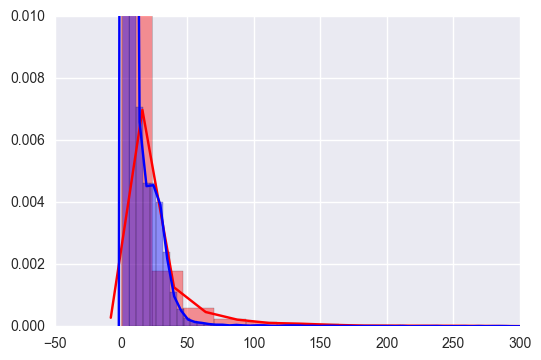

In [41]:
truenp = np.squeeze(np.array(trues).astype(np.float32), axis = 1)
sub1 = pred_df[pred_df['ChromHMM State'] == 'All\n205984\n0.342\n307.7']
truedf = np.array(sub1[sub1['Type'] == 'Experimental Signal']['SuRE Fragment Score']).astype(np.float32)

prednp = np.squeeze(np.array(preds).astype(np.float32), axis = 1)
sub2 = pred_df[pred_df['ChromHMM State'] == 'All\n205984\n0.342\n307.7']
preddf = np.array(sub2[sub2['Type'] == 'Predicted Signal']['SuRE Fragment Score']).astype(np.float32)

truenp = np.sort(truenp)
truedf = np.sort(truedf)

prednp = np.sort(prednp)
preddf = np.sort(preddf)

print truenp.shape
print truedf.shape

print prednp.shape
print preddf.shape

from scipy.stats import spearmanr
print spearmanr(truenp,truedf)
print spearmanr(prednp,preddf)

print str(np.mean(truenp)) + " " + str(np.std(truenp)) + " " + str(np.median(truenp))
print str(np.mean(truedf)) + " " + str(np.std(truedf)) + " " + str(np.median(truedf))

print str(np.mean(prednp)) + " " + str(np.std(prednp)) + " " + str(np.median(prednp))
print str(np.mean(preddf)) + " " + str(np.std(preddf)) + " " + str(np.median(preddf))

import seaborn as sns

sns.set()

ax = sns.distplot(truenp, 
             color = 'r', 
#              hist=False, 
#              shade=True,
            norm_hist=False, 
#             kde=False,
            bins=100,
           );
sns.distplot(preddf, 
             color = 'b', 
#              hist=False, 
#              shade=True
             norm_hist=False,
#              kde=False,
             bins=100,
           );
ax.set_xlim(-50,300)
ax.set_ylim(None, 0.010)
# sns.plt.show()

In [ ]:
import seaborn as sns

sns.set()

ax = sns.distplot(pred_df[pred_df['Type'] == 'Predicted Signal']['SuRE Fragment Score'], 
             color = 'r', 
#              hist=False, 
#              shade=True,
            norm_hist=False, 
            kde=False,
           );
sns.distplot(pred_df[pred_df['Type'] == 'Experimental Signal']['SuRE Fragment Score'], 
             color = 'b', 
#              hist=False, 
#              shade=True
             norm_hist=False,
             kde=False,
           );
ax.set_xlim(-10, 100)

In [ ]:
print np.array(trues)[:10]
pred_df = pred_df.sort_values(by='')
pred_df[pred_df['Type'] == 'Experimental Signal']['SuRE Fragment Score'][:10]

In [ ]:
sns.set()

ax = sns.distplot(trues, 
             color = 'b', 
#              hist=False, 
#              shade=True
             norm_hist=False,
             kde=True,
             bins=1000
           );
ax.set_xlim(-10, 100);
# ax.set_ylim(-10, 400000);

ax = sns.distplot(preds, 
             color = 'r', 
#              hist=False, 
#              shade=True
             norm_hist=False,
             kde=True,
             bins=1000
           );
ax.set_xlim(-10, 100);
# ax.set_ylim(-10, 125000);

In [ ]:
print np.mean(trues)
print np.std(trues)
print len(trues)

print np.mean(preds)
print np.std(preds)
print len(preds)

In [ ]:
print pred_df[pred_df['Type'] == 'Experimental Signal']['SuRE Fragment Score'][:20]

In [ ]:
# print pred_df[pred_df['Type'] == 'Predicted Signal'].shape
# print pred_df[pred_df['Type'] == 'Experimental Signal'].shape
pred_df[pred_df['Type'] == 'Predicted Signal'][:10]

In [ ]:
import matplotlib.font_manager
matplotlib.font_manager.findSystemFonts(fontpaths=None, fontext='ttf')

In [ ]:
!echo $CONDA_DEFAULT_ENV

In [ ]:
import matplotlib.pyplot as plt
from collections import Counter

# print np.argmax(data.Y)
top_idxs = np.argsort(np.squeeze(data.Y, axis=1), axis = 0)[::-1][:1000][::2]
states_list = [index_annotations[idx][0] for idx in top_idxs]
print Counter(states_list)

# curating the ones that were predicted accurately -- i.e., prediction within some percentage of true value
top_idxs_curated = []
selected_chromhmm_states = ['Pol2', 'Tss', 'TssF', 'PromF', 'PromP']
for idx in top_idxs:
    percentThreshold = 30.0
    true_score = data.Y[idx]
    pred_score = deeplift_model_predictions[idx]
    if (pred_score > (1 - percentThreshold / 100) * true_score and 
        pred_score < (1 + percentThreshold / 100) * true_score and
        index_annotations[idx][0] in selected_chromhmm_states):
        print index_annotations[idx][0]
        top_idxs_curated.append(idx)
    
print len(top_idxs)
print len(top_idxs_curated)

for idx in top_idxs_curated:
# for idx in top_idxs_curated:
    print "Validation datapoint index " + str(idx)
    print "Assay fragment score: " + str(data.Y[idx][0])
    print "Predicted fragment score: " + str(deeplift_model_predictions[idx][0])
    state = index_annotations[idx][0]
    print "Fragment chromHMM state: " + state
    plt.plot(task_to_deeplift_scores[0][idx])
    seqLen = np.sum(data.X[idx])
    print "Sequence length: " + str(int(seqLen))
    plt.axvline(x = 1000 - seqLen/2 - 1, color = 'r', linestyle = '--')
    plt.axvline(x = 1000 + seqLen/2 + 1, color = 'r', linestyle = '--')
    topBase = np.argmax(np.abs(task_to_deeplift_scores[0][idx]))
    plt.axvline(x = topBase, color = 'g', linewidth = 4, linestyle = ':')
    
    fragment = fragments[idx]
    print "Genomic region: " + fragment
    centerPos = int(fragment[fragment.find(":") + 1 : fragment.find("-")]) + seqLen / 2
    topBasePos = int(centerPos + topBase - 1000)
    chrom = fragment[:fragment.find(":")]
    print "Top DeepLIFT scored base: " + chrom + ":" + str(topBasePos)
    plt.title(fragment + ", " + state)
    plt.xlabel("Relative Genomic Position")
    plt.ylabel("DeepLIFT Score")
    plt.show()
    plt.clf()

# Motif discovery with DeepLIFT

In [ ]:
%matplotlib inline
# from __future__ import print_function
from simdna import synthetic as sn
import avutils
from avutils import file_processing as fp
import numpy as np
from collections import OrderedDict
# import tutorial_utils
# from tutorial_utils import viz_sequence_highlight_motifs
from deeplift.blobs import NonlinearMxtsMode, DenseMxtsMode
import deeplift
import deeplift.conversion.keras_conversion as kc
from deeplift.visualization import viz_sequence
# import modisco_tutorial

In [ ]:
# Load the keras model, make sure you normalise the weights
# of the first convolutional layer to be mean-centered at each position.
modelName = "record_4_model_iGIVc_"
modelJson = "../model_files/regression_jul3_strands_augmented/" + modelName + "modelJson.json"
modelWeights = "../model_files/regression_jul3_strands_augmented/" + modelName + "modelWeights.h5"
reload(kc)
keras_model = kc.load_keras_model(modelWeights, json=modelJson)

In [ ]:
deeplift_model = kc.convert_sequential_model(keras_model,
                  nonlinear_mxts_mode=deeplift.blobs.NonlinearMxtsMode.DeepLIFT_GenomicsDefault)

In [ ]:
import h5py
valid_data = h5py.File("../hdf5files/regression_jul3_strands_augmented_rep2only/valid_data.hdf5")
one_hot_data = valid_data['X']['sequence']
modisco_reference = np.array([0.2905, 0.205, 0.2075, 0.297])[None,None,:]
task_idx=0

In [ ]:
true_outputs = valid_data['Y']['output']
true_outputs = np.squeeze(true_outputs, axis=1)
print true_outputs.shape
numPositives = 20000
positiveIndices = np.argsort(true_outputs)[::-1][:numPositives]
true_outputs_positives = true_outputs[positiveIndices]
one_hot_data_positives = np.array(one_hot_data)[positiveIndices]

In [ ]:
print true_outputs_positives.shape
print one_hot_data_positives.shape
# performance on this data subset
y_pred = keras_model.predict(one_hot_data_positives)
y_pred = np.squeeze(y_pred, axis=1)
from scipy.stats import spearmanr
print spearmanr(y_pred, true_outputs_positives)

In [ ]:
# Just realized Spearman correlation is being artificially increased by using "duplicated" (RevComp) sequences
# in the validation set. How much does correlation go down when these are excluded?
print spearmanr(y_pred[::2], true_outputs_positives[::2])
# Hm, interesting, correlation only goes from 0.3242 to 0.3236. That's cool. I guess Spearman correlation
# is robust to repeated values.

In [ ]:
# get contributions of conv layer 1 filters

conv_layer_contribs_func = deeplift_model.get_target_contribs_func(
                            find_scores_layer_idx = 1,
                            target_layer_idx = -1)

In [ ]:
conv_layer_contribs = np.array(conv_layer_contribs_func(
                                task_idx=task_idx,
                                input_data_list=[one_hot_data_positives],
                                input_references_list=[modisco_reference],
                                batch_size=500, progress_update=10000))

In [ ]:
print conv_layer_contribs.shape

In [ ]:
import matplotlib.pyplot as plt

per_filter_scores = np.mean(np.squeeze(conv_layer_contribs), axis=(1,0))
print per_filter_scores.shape

fig, ax = plt.subplots()

ax = plt.subplot(211)
ax.hist(per_filter_scores, bins=50, normed=False, stacked=False)
ax.set_xlabel('Avg DeepLIFT Score by Filter')
ax.set_ylabel('Number of Filters')

per_position_scores = np.mean(np.squeeze(conv_layer_contribs), axis=(2,0))
print per_position_scores.shape

ax = plt.subplot(212)
ax.hist(per_position_scores, bins=50, normed=False, stacked=False)
ax.set_xlabel('Avg DeepLIFT Score by Position')
ax.set_ylabel('Number of Positions')

fig.tight_layout()
plt.show()

In [ ]:
conv_weights, conv_biases = keras_model.layers[0].get_weights()

# The shape of the weights is:
# filter length x number of channels x kernel height (acgt) x number of filters
print("conv_weights shape",conv_weights.shape)
# this tutorial assumes shape number of filters x number of input channels x kernel height (acgt) x filter length
conv_weights = np.swapaxes(conv_weights, 0, 3)
# There is one bias per filter.
print("conv_biases shape",conv_biases.shape)

# Sort channels in descending order of importance
channels_sorted_by_importance = sorted(
    zip(conv_weights, conv_biases, per_filter_scores),
    key=lambda x: -x[2])

# print len(channels_sorted_by_importance)

# Plot the weights of the top channels
for i in range(0,2):
    this_filter_bias = channels_sorted_by_importance[i][1]
    this_filter_weights = channels_sorted_by_importance[i][0][0]
#     print this_filter_weights.shape
    this_filter_importance = channels_sorted_by_importance[i][2]
    # Normalize the weights so that each position effectively 
    print("importance: "+str(this_filter_importance)+" bias: "+str(this_filter_bias))
    viz_sequence.plot_weights(this_filter_weights, figsize=(10,2))

In [ ]:
# Add modisco tutorial directory to system path so that we can import scripts when nec
import sys
sys.path.insert(0, '/scratch/users/rmovva/mpra/deeplearn/scripts/deeplift_modisco_tutorial/')
print sys.path[0]

In [ ]:
sequence_contribs_func = deeplift_model.get_target_contribs_func(
                                    find_scores_layer_idx=0,
                                    target_layer_idx=-1)
sequence_contribs = np.array(
                        sequence_contribs_func(task_idx=task_idx,
                            input_data_list=[one_hot_data_positives],
                            input_references_list=[modisco_reference],
                            batch_size=500, progress_update=10000))

In [ ]:
print("Shape:",sequence_contribs.shape)
print(sequence_contribs[0,1000:1003,:])

In [ ]:
sequence_contribs_summed = np.sum(sequence_contribs,axis=-1)[:,:,None]*one_hot_data_positives
print sequence_contribs_summed.shape

In [ ]:
print(sequence_contribs_summed[0,1000:1003,:])

In [ ]:
import modisco_tutorial

segment_identifier = modisco_tutorial.FixedWindowAroundPeaks(
                                        sliding_window_for_max_size=7,
                                        flank_to_expand_around_peak_size=3,
                                        exclude_peaks_within_window=7,
                                        ratio_to_top_peaks_to_include=0.3,
                                        max_segments=6)

In [ ]:
# convert from NumExamples, SequenceLength, ACGT to NumExamples, 1, ACGT, SequenceLength

sequence_contribs_reshaped = np.swapaxes(np.expand_dims(sequence_contribs, axis=1), 2, 3)

seqlets, seqlet_indices = modisco_tutorial.get_seqlets(
                            raw_importance_contribs=sequence_contribs_reshaped,
                            segment_identifier=segment_identifier,
#                             rev_comp_func=modisco_tutorial.dna_rev_comp_func
                          )

# Filter out any shorter seqlets from the edges of sequences
seqlets = modisco_tutorial.filter_shorter_seqlets(seqlets)

print("Total seqlets:",len(seqlets))

In [ ]:
# Augment tracks
for (full_data_arr,
     name,
     pseudocount) in [
       (np.swapaxes(one_hot_data_positives, 1, 2).astype("float"),
        "sequence",
        0.25 #pseudocount
        # Pseudocounts are useful when seqlets are merged
        # into a motif (later), but we don't want to be
        # overconfident in the frequency of bases at any
        # particular position. 0.25 means that each
        # 'pseudocount' at a particular position carries
        # a value of 0.25       
       ),
       (np.swapaxes(sequence_contribs_summed, 1, 2), #data
        "summed_multiplier_contribs",
        0.0)]:
    modisco_tutorial.augment_seqlets_with_data(
        seqlets,
        full_data_arr=full_data_arr,
        fullRevCompDataArr=full_data_arr,
        key_name=name,
        pseudocount=pseudocount,
#         rev_comp_func=modisco_tutorial.dna_rev_comp_func
    )

In [ ]:
# Visually explore some seqlets as a sanity check
track_names_to_print=["sequence", "summed_multiplier_contribs", "core_importance_track"]
for idx in [2,60]:
    print("Seqlet with idx",idx)
    for track_name in track_names_to_print:
        print("Track:",track_name)
        viz_sequence.plot_weights(seqlets[idx].get_summed_data_track(track_name),
                                  figsize=(10,1))

In [ ]:
reload(modisco_tutorial)

seqlets_corr_mat = modisco_tutorial.get_correlation_matrix(
    seqlets,
    # Use the mutlipliers to do the correlation
    subtracks_to_align_on=["core_importance_track"],
    # In this simulated data, there are no reverse complements - however,
    # in general it is important to account for the reverse complement
    # when computing the distance matrix, so we leave this at True
    account_for_rev_comp=False,
    batch_size=200)

In [ ]:
reload(modisco_tutorial)

# Find the t-sne embedding using the distance metric
np.random.seed(710)

num_seqlets = len(seqlets_corr_mat)
# num_seqlets = 25000
# indices = np.random.choice(range(len(seqlets_corr_mat)), num_seqlets, replace=False)
# seqlets_corr_mat_subset = seqlets_corr_mat[np.ix_(indices, indices)]
# print seqlets_corr_mat_subset.shape
embedding_corr = modisco_tutorial.get_tsne_embedding_of_modisco_motifs(
                    seqlets_corr_mat, perplexity=50, verbose=2)
modisco_tutorial.scatter_plot(embedding_corr, save = True, savepath = "../model_files/regression_jul3_strands_augmented/interpretation/tsne/tsneRaw.png")

In [ ]:
import sklearn.cluster
reload(deeplift.visualization.viz_sequence)
from deeplift.visualization import viz_sequence
import os

n_cluster_list = [1,2,5,10,25,50,100,200]
# n_cluster_list = n_cluster_list[1:]
for n_clusters in n_cluster_list:
    print "N_clusters = " + str(n_clusters)
    print "Running k-means..."
    kmeans_clusters = sklearn.cluster.KMeans(n_clusters=n_clusters, n_init=10).fit_predict(embedding_corr)
    print "Plotting k-means..."
    modisco_tutorial.scatter_plot(embedding_corr, 
                                  labels=kmeans_clusters, 
                                  save = True, 
                                  savepath = ("../model_files/regression_jul3_strands_augmented/interpretation/" +
                                              "tsne/tsne_kmeans_" + str(n_clusters) + "clusters.png"))
    
    print "Merging motifs..."
    merged_motifs = modisco_tutorial.create_merged_modisco_motifs(
                    kmeans_clusters, seqlets,
                    subtracks_to_align_on=["core_importance_track"],
                    account_for_rev_comp=False)
    
    trimming_func = modisco_tutorial.TrimArrayColumnsToNumUnderlyingObs(0.5)
    merged_motifs = modisco_tutorial.adjust_modisco_motifs_using_trimming_criterion(
                    merged_motifs,
                    trimming_func=trimming_func)
    
    dirName = "../model_files/regression_jul3_strands_augmented/interpretation/modisco/modisco_" + str(n_clusters) + "motifs/"
    if os.path.isdir(dirName) == False:
        os.mkdir(dirName)
    
    print "Plotting motifs..."
    for motif_idx, motif in enumerate(merged_motifs.values()):
        print("On motif",motif_idx)
        for track_name in ["sequence", "summed_multiplier_contribs", "core_importance_track"]:
            if n_clusters > 25:
                show = False
            else:
                show = True
                
            viz_sequence.plot_weights(
                motif.get_summed_data_track(track_name),
                figsize=(20,2),
                show = show,
                save = True,
                savepath=(dirName + "motif_" + track_name + "_" + str(motif_idx) + ".png"))

In [ ]:
import time
t0 = time.time()
input_data_sequences = []
print_interval = int(2e4)
seq_pad_lengths = []
for (i, seq) in enumerate(one_hot_data_positives):
    if i % print_interval == 0 and i > 0:
        print ("Converting sequences " + str(i - print_interval) +
               " to " + str(i) + " from one-hot to ACGT strings took " +
               str(round(time.time() - t0, 3)) + "s.")
        t0 = time.time()
    char_seq, pads = convert_one_hot_seq_to_acgt(seq)
    input_data_sequences.append(char_seq)
    seq_pad_lengths.append(pads)

In [ ]:
import avutils
reload(deeplift)
reload(deeplift.dinuc_shuffle)
from deeplift.dinuc_shuffle import dinuc_shuffle

seed = 710
conv_layer_contribs_many_refs_func = deeplift.util.get_shuffle_seq_ref_function(
                                score_computation_function=conv_layer_contribs_func, #supply any deeplift scoring function
                                shuffle_func=deeplift.dinuc_shuffle.dinuc_shuffle,
                                seed=seed,
                                #func to one-hot encode array of sequences:
                                # one_hot_func=lambda x: np.array([np.swapaxes(avutils.util.seq_to_one_hot(seq), 0, 1) for seq in x]) #theano_seq_to_2d_image, seq_to_one_hot
                                one_hot_func=lambda x: np.array([avutils.util.seq_to_one_hot(seq) for seq in x]) #theano_seq_to_2d_image, seq_to_one_hot
                            )

conv_layer_contribs_dinucshuffled_refs = np.array(conv_layer_contribs_many_refs_func(
                                                      task_idx = task_idx,
                                                      input_data_sequences=input_data_sequences,
                                                      num_refs_per_seq=10,
                                                      batch_size=200,
                                                      padded_length=2000,
                                                      pad_lengths=seq_pad_lengths,
                                                      progress_update=20000))